In [0]:
# Copyright 2018 The TensorFlow GAN Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-GAN on TPUs Tutorial

Tutorial authors: joelshor@google.com, westbrook@google.com, tomfeelslucky@google.com

## Overview


This colab walks you through the basics of using TensorFlow GAN (TF-GAN) on Tensor Processing Units (TPUs).

It assumes that you have gone through the [Generative Adversarial Network Self Study Course](http://go/tfgan-ss), or have equivalent familiarity with GAN concepts.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

### TPUs

TPUs are chips optimized for machine learning training and inference. GAN training uses a lot of compute power, so TPUs expand the range of what we can realistically accomplish with GANs.

### CIFAR10 Task

In this colab we'll use TPUs to train a GAN for a more difficult task than the MNIST task tackled in the [GANEstimator](https://goto.google.com/tfgan-tutorial) colab. We'll use the [CIFAR10](https://wikipedia.org/wiki/CIFAR-10) dataset to train a model to generate images of airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The training runs for 50000 steps and completes in roughly 10 minutes on TPUs.

### DCGAN Architecture

Our model implements the Deep Convolutional Generative Adversarial Network (DCGAN) architecture. [Convolutional Neural Networks](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNNs) are a common machine learning technique for dealing with images. DCGAN adapts a CNN architecture so that it can function as part of a GAN.

## Learning objectives

In this Colab, you will learn how to:
*   Build a simple DCGAN generator and discriminator
*   Use a TPUGANEstimator from TF-GAN to train on CIFAR10 data.
*   Run the model forward and see how well it generates images.


## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

### Steps to run this notebook

This notebook should be run in Colaboratory. If you are viewing this from GitHub, follow the GitHub instructions. If you are viewing this from Colaboratory, you should skip to the Colaboratory instructions.

#### Steps from GitHub

1. Navigate your web brower to the main Colaboratory website: https://colab.research.google.com.
1. Click the `GitHub` tab.
1. In the field marked `Enter a GitHub URL or search by organization or user`, put in the URL of this notebook in GitHub and click the magnifying glass icon next to it.
1. Run the notebook in colaboratory by following the instructions below.

#### Steps from Colaboratory

1. Create a Cloud Storage bucket for your TensorBoard logs at http://console.cloud.google.com/storage.
1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `TPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.
1. Click Runtime again and select **Runtime > Run All** (Watch out: the initial authentication step for this notebook  requires that you click on `use_tpu` and supply a bucket name as input). You can also run the cells manually with Shift-ENTER.  

## Testing out the TPU connection

First, you'll need to enable TPUs for the notebook.

Navigate to Edit→Notebook Settings, and select TPU from the Hardware Accelerator drop-down (you can also access Notebook Settings via the command palette: cmd/ctrl-shift-P).

Next, we'll check that we can connect to the TPU.

In [0]:
import os
import tensorflow as tf
import pprint
assert 'COLAB_TPU_ADDR' in os.environ, 'Did you forget to switch to TPU?'
tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']

with tf.Session(tpu_address) as sess:
  devices = sess.list_devices()
pprint.pprint(devices)
device_is_tpu = [True if 'TPU' in str(x) else False for x in devices]
assert True in device_is_tpu, 'Did you forget to switch to TPU?'

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, -1, 12554852702432587163),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1956706439366282376),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17999285147157611628),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13766411731503274473),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 17179869184, 5145475857503320419),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12082130444165129243),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 17179869184, 11316350311501455592),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 17179869184, 3831533973859009198),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 17179869184, 2691703816632397053),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:T

### Authentication

In [0]:
import json
import os
import pprint
import re
import time
import tensorflow as tf

# Google Cloud Storage bucket for Estimator logs and storing
# the training dataset.
bucket = '' #@param {type:"string"}

assert bucket, 'Must specify an existing GCS bucket name'
print('Using bucket: {}'.format(bucket))

model_dir = 'gs://{}/{}'.format(
    bucket, time.strftime('tpuestimator-tfgan/%Y-%m-%d-%H-%M-%S'))
print('Using model dir: {}'.format(model_dir))

from google.colab import auth
auth.authenticate_user()

assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'
tpu_address = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

# Upload credentials to TPU.
with tf.Session(tpu_address) as sess:    
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
# Now credentials are set for all future sessions on this TPU.

### Check imports

In [0]:
# Check that imports for the rest of the file work.
import os
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline
# Disable noisy outputs.
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

## Train and evaluate a GAN model on TPU using TF-GAN.


### Input pipeline

Make the train, eval, and predict input functions.

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset_dir = 'gs://{}/{}'.format(bucket, 'datasets')

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0)
              .map(lambda _: tf.random_normal([bs, nd]))
              # If 'predict', just generate one batch.
              .repeat(1 if just_noise else None))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('cifar10', split=split, data_dir=dataset_dir)
               .map(_preprocess, num_parallel_calls=4)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))


def noise_input_fn(params):
  np.random.seed(0)
  np_noise = np.random.randn(params['batch_size'], params['noise_dims'])
  return tf.data.Dataset.from_tensors(tf.constant(np_noise, dtype=tf.float32))

Download the data. TensorFlow Datsets will write the data once to your GCS bucket, then reuse it for future calls.

In [0]:
params = {'batch_size': 1, 'noise_dims':1}
input_fn(tf.estimator.ModeKeys.EVAL, params)

Sanity check the inputs.


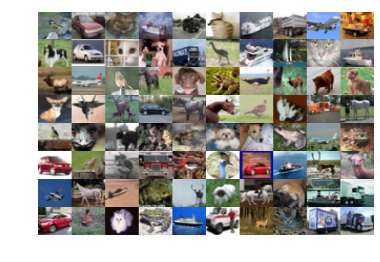

In [0]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan

params = {'batch_size': 80, 'noise_dims':64}
ds = input_fn(tf.estimator.ModeKeys.EVAL, params)
numpy_imgs = tfds.as_numpy(ds).next()[1]
image_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(8, 10))

def _show_image_grid(image_grid):
  plt.axis('off')
  plt.imshow((image_grid + 1.0) / 2.0,  # [-1, 1] -> [0, 1]
             aspect='auto')
  plt.show()
_show_image_grid(image_grid)

### Neural Net Architecture

As usual, our GAN has two separate networks:

*  A generator that takes input noise and outputs images
*  A discriminator that takes images and outputs a probability of being real

We define `discriminator()` and `generator()` builder functions that assemble these networks, along with several helper functions that build pieces of these networks. In the "Estimator" section below we pass the `discriminator()` and `generator()` functions to the `TPUGANEstimator`

In [0]:
def _leaky_relu(x):
  return tf.nn.leaky_relu(x, alpha=0.2)


def _batch_norm(x, is_training, name):
  return tf.layers.batch_normalization(
      x, momentum=0.9, epsilon=1e-5, training=is_training, name=name)


def _dense(x, channels, name):
  return tf.layers.dense(
      x, channels,
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
      name=name)


def _conv2d(x, filters, kernel_size, stride, name):
  return tf.layers.conv2d(
      x, filters, [kernel_size, kernel_size],
      strides=[stride, stride], padding='same',
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
      name=name)


def _deconv2d(x, filters, kernel_size, stride, name):
  return tf.layers.conv2d_transpose(
      x, filters, [kernel_size, kernel_size],
      strides=[stride, stride], padding='same',
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
      name=name)


def discriminator(images, unused_conditioning, is_training=True,
                  scope='Discriminator'):
  """Discriminator for CIFAR images.

  Args:
    images: A Tensor of shape [batch size, width, height, channels], that can be
      either real or generated. It is the discriminator's goal to distinguish
      between the two.
    unused_conditioning: The TFGAN API can help with conditional GANs, which
      would require extra `condition` information to both the generator and the
      discriminator. Since this example is not conditional, we do not use this
      argument.
    is_training: If `True`, batch norm uses batch statistics. If `False`, batch
      norm uses the exponential moving average collected from population
      statistics.
    scope: A variable scope or string for the discriminator.

  Returns:
    A 1D Tensor of shape [batch size] representing the confidence that the
    images are real. The output can lie in [-inf, inf], with positive values
    indicating high confidence that the images are real.
  """
  with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
    x = _conv2d(images, 64, 5, 2, name='d_conv1')
    x = _leaky_relu(x)

    x = _conv2d(x, 128, 5, 2, name='d_conv2')
    x = _leaky_relu(_batch_norm(x, is_training, name='d_bn2'))

    x = _conv2d(x, 256, 5, 2, name='d_conv3')
    x = _leaky_relu(_batch_norm(x, is_training, name='d_bn3'))

    x = tf.reshape(x, [-1, 4 * 4 * 256])

    x = _dense(x, 1, name='d_fc_4')

    return x


def generator(noise, is_training=True, scope='Generator'):
  """Generator to produce CIFAR images.

  Args:
    noise: A 2D Tensor of shape [batch size, noise dim]. Since this example
      does not use conditioning, this Tensor represents a noise vector of some
      kind that will be reshaped by the generator into CIFAR examples.
    is_training: If `True`, batch norm uses batch statistics. If `False`, batch
      norm uses the exponential moving average collected from population
      statistics.
    scope: A variable scope or string for the generator.

  Returns:
    A single Tensor with a batch of generated CIFAR images.
  """
  with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
    net = _dense(noise, 4096, name='g_fc1')
    net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn1'))

    net = tf.reshape(net, [-1, 4, 4, 256])

    net = _deconv2d(net, 128, 5, 2, name='g_dconv2')
    net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn2'))

    net = _deconv2d(net, 64, 4, 2, name='g_dconv3')
    net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn3'))

    net = _deconv2d(net, 3, 4, 2, name='g_dconv4')
    net = tf.tanh(net)

    return net

### Eval Utilities

We evaluate the performance of our generator using two standard metrics based on a pretrained classifier: the `Inception Score` and the `Frechet Inception Distance`.


In [0]:
import tensorflow as tf
import tensorflow_gan as tfgan
import tensorflow_hub as hub
import numpy as np

eval_batch_size = 4000 #@param
images_per_batch = 2000 #@param

def get_real_image_logits(num_images, classifier_model):
  """Returns an array with logits from real images and a CIFAR classifier.
  
  We normally want many thousands of examples to run eval. However, we can't fit
  inference for all of them in memory at once. Instead, we use TF-GAN eval utils
  to more efficiently manage memory.

  Args:
    num_images: Total number of images to produce logits for.
    classifier_model: A Python function that takes images and produces logits.

  Returns:
    A numpy array of logits of shape close to [num_images, ?].
  """
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, 
                {'batch_size': images_per_batch, 'noise_dims': 1})
  iterator = tf.data.make_one_shot_iterator(ds)

  real_logits = tfgan.eval.sample_and_run_classifier_fn(
      sample_fn=lambda _: iterator.get_next()[1],
      sample_inputs=[0.0] * (num_images // images_per_batch),  # unused
      classifier_fn=classifier_model)
  
  with tf.train.MonitoredSession() as sess:
    logits = sess.run(real_logits)
  assert len(logits.shape) == 2
  assert logits.shape[0] == num_images
  return logits

def init_global_real_logits():
  """Initialize a global variable with classifier logits for real data."""
  # We can hold all the real logits in memory at once, since CIFAR10 isn't that
  # big. Be sure to calculate it only once.
  global real_logits
  try:
    real_logits is not None
  except NameError:
    with tf.Graph().as_default():
      classifier_model = hub.Module("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1")
      real_logits = get_real_image_logits(
          eval_batch_size, classifier_model)
  assert real_logits.shape == (eval_batch_size, 10)
  
def calculate_real_data_classifier_score():
  """Calculate the classifier score on real data logits."""
  assert real_logits is not None
  classifier_score = tfgan.eval.classifier_score_from_logits(real_logits)
  with tf.train.MonitoredSession() as sess:
    cscore_real = sess.run(classifier_score)
  return cscore_real


def get_inception_score_and_fid(est):
  """Calculate our evaluation metrics."""
  global real_logits
  assert real_logits is not None

  tf.reset_default_graph()
  classifier_model = hub.Module("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1")

  # We dont' want to hold all the images and activations at once, so use a
  # memory-efficient utility.
  def sample_fn(_):
    predictions = np.array([x['generated_data'] for x in est.predict(input_fn)])
    assert predictions.shape == (images_per_batch, 32, 32, 3)
    return predictions
  fake_logits = tfgan.eval.sample_and_run_classifier_fn(
      sample_fn=sample_fn,
      sample_inputs=[0.0] * (eval_batch_size // images_per_batch),  # unused
      classifier_fn=classifier_model)
  fake_logits.shape.assert_is_compatible_with([eval_batch_size, 10])

  classifier_score = tfgan.eval.classifier_score_from_logits(fake_logits)
  fid = tfgan.eval.frechet_classifier_distance_from_activations(
      real_logits, fake_logits)

  with tf.train.MonitoredSession() as sess:
    cscore_np, fid_np = sess.run([classifier_score, fid])
  
  return cscore_np, fid_np

### Estimator

TF-GAN's `TPUGANEstimator` is like `GANEstimator`, but it extends TensorFlow's `TPUEstimator` class. `TPUEstimator` handles the details of deploying the network on a TPU.

In [0]:
import os
import tensorflow as tf
import tensorflow_gan as tfgan

noise_dims = 1024 #@param
generator_lr = 0.0002  #@param
discriminator_lr = 0.0002  #@param
train_batch_size = 1024  #@param

config = tf.contrib.tpu.RunConfig(
    model_dir=model_dir,
    master=tpu_address,
    tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=images_per_batch))
est = tfgan.estimator.TPUGANEstimator(
    generator_fn=generator,
    discriminator_fn=discriminator,
    generator_loss_fn=tfgan.losses.modified_generator_loss,
    discriminator_loss_fn=tfgan.losses.modified_discriminator_loss,
    generator_optimizer=tf.train.AdamOptimizer(generator_lr, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    joint_train=True,  # train G and D jointly instead of sequentially.
    train_batch_size=train_batch_size,
    predict_batch_size=images_per_batch,
    use_tpu=True,
    params={'noise_dims': noise_dims},
    config=config)

### Train and Eval Loop

Train, eval, and vizualize.

Initialized classifier logits for real data.
Calculated classifier score for real data.
Current step: 5000, 97.3732 steps / sec, time since start: 1.4 min
Classifier score: 3.14 / 7.26, FID: 30.5, time to calculate eval: 38.73 sec


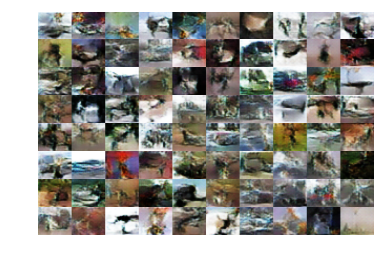

Current step: 10000, 93.0245 steps / sec, time since start: 3.1 min
Classifier score: 3.68 / 7.26, FID: 12.2, time to calculate eval: 41.35 sec


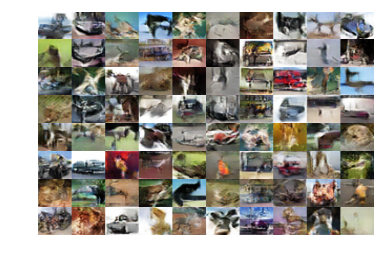

Current step: 15000, 95.1444 steps / sec, time since start: 4.8 min
Classifier score: 3.91 / 7.26, FID: 7.5, time to calculate eval: 40.62 sec


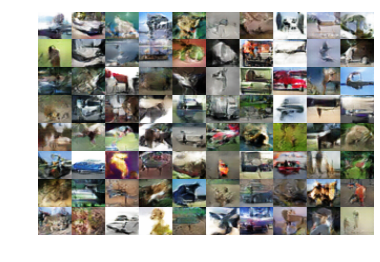

Current step: 20000, 97.7581 steps / sec, time since start: 6.5 min
Classifier score: 3.97 / 7.26, FID: 7.7, time to calculate eval: 38.64 sec


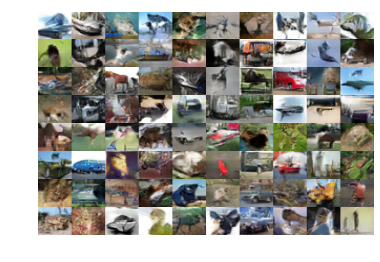

Current step: 25000, 93.8263 steps / sec, time since start: 8.2 min
Classifier score: 4.02 / 7.26, FID: 9.1, time to calculate eval: 40.32 sec


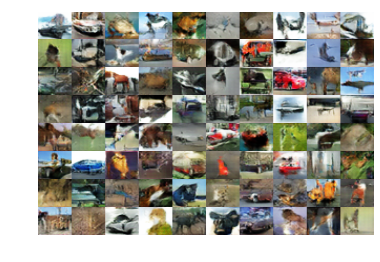

Current step: 30000, 92.6514 steps / sec, time since start: 9.9 min
Classifier score: 4.20 / 7.26, FID: 6.1, time to calculate eval: 36.79 sec


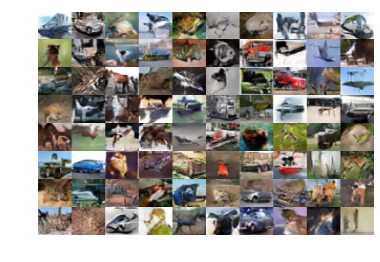

Current step: 35000, 94.3770 steps / sec, time since start: 11.5 min
Classifier score: 4.09 / 7.26, FID: 7.2, time to calculate eval: 32.41 sec


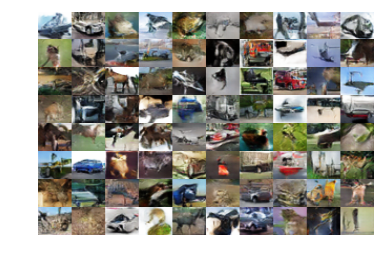

Current step: 40000, 92.1802 steps / sec, time since start: 13.1 min
Classifier score: 4.13 / 7.26, FID: 5.7, time to calculate eval: 34.10 sec


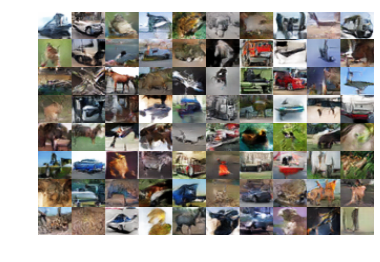

Current step: 45000, 91.4288 steps / sec, time since start: 14.8 min
Classifier score: 4.21 / 7.26, FID: 6.1, time to calculate eval: 28.33 sec


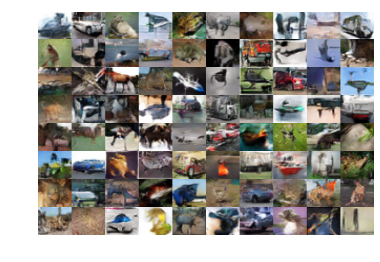

Current step: 50000, 92.7790 steps / sec, time since start: 16.3 min
Classifier score: 4.24 / 7.26, FID: 5.3, time to calculate eval: 41.48 sec


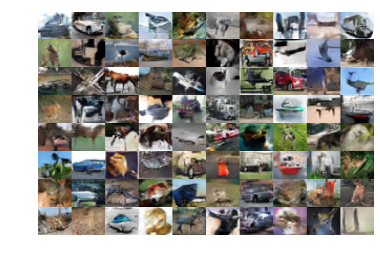

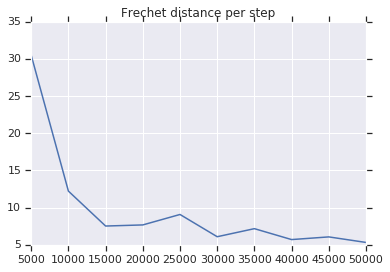

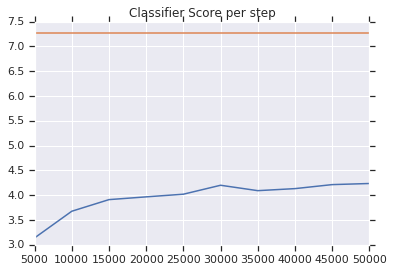

In [0]:
import time
import matplotlib.pyplot as plt

max_steps = 50000 #@param
steps_per_eval = 5000 #@param

cur_step = 0
start_time = time.time()
cscores, fids, steps = [], [], []
init_global_real_logits()
print('Initialized classifier logits for real data.')
classifier_score_real_data = calculate_real_data_classifier_score()
print('Calculated classifier score for real data.')
while cur_step < max_steps:
  # Train for a fixed number of steps.
  start_step = cur_step
  step_to_stop_at = min(cur_step + steps_per_eval, max_steps)
  start = time.time()
  est.train(input_fn, max_steps=step_to_stop_at)
  end = time.time()
  cur_step = step_to_stop_at
  
  # Print some performance statistics.
  steps_taken = step_to_stop_at - start_step
  time_taken = end - start
  steps_per_sec = steps_taken / time_taken
  min_since_start = (time.time() - start_time) / 60.0
  print("Current step: %i, %.4f steps / sec, time since start: %.1f min" % (
      cur_step, steps_per_sec, min_since_start))
  
  # Calculate some evaluation metrics.
  eval_start_time = time.time()
  cscore, fid = get_inception_score_and_fid(est)
  eval_time = (time.time() - eval_start_time)
  cscores.append(cscore)
  fids.append(fid)
  steps.append(cur_step)
  print("Classifier score: %.2f / %.2f, FID: %.1f, "
        "time to calculate eval: %.2f sec" % (
            cscore, classifier_score_real_data, fid, eval_time))
  
  # Generate and show some predictions.
  predictions = np.array(
      [x['generated_data'] for x in est.predict(noise_input_fn)])[:80]
  image_grid = tfgan.eval.python_image_grid(predictions, grid_shape=(8, 10))
  _show_image_grid(image_grid)

# Plot the metrics vs step.
plt.title('Frechet distance per step')
plt.plot(steps, fids)
plt.figure()
plt.title('Classifier Score per step')
plt.plot(steps, cscores)
plt.plot(steps, [classifier_score_real_data] * len(steps))
plt.figure()